In [89]:
# Bayesian Linear Regression - November 2017

%matplotlib inline

import numpy as np
import pylab as pb
import matplotlib.pyplot as plt
from math import pi
from numpy.linalg import norm
#from mpl_toolkits.mplot3d import Axes3D
#from matplotlib import cm

# Makes the 3D plot interactive
#%matplotlib notebook

In [90]:
# Parameters
sigma = 0.4
omega_0 = 1.5
omega_1 = -0.8
set_size = 202

# 0 to plot posterior distribution of a random data point and 1 to plot posterior distribution of whole data set
plot_option = 0

point_set = np.array([])
X_plot = np.array([])
T_plot = np.array([])

In [91]:
# Multivariate Gaussian

epsilon = np.zeros(set_size)
for i in range(set_size):
    epsilon[i] = np.random.normal(0, sigma)

In [92]:
# Generates data points

X = np.linspace(-2, 2, set_size)
T = omega_0*X + omega_1 + epsilon

In [93]:
# Initializes some functions and the parameters for the sampling

# Make sure this is an even value
plot_size = 400

x_axis = np.array([0,2.5])
y_axis = np.array([-2,0.5])

# Set of possible values for parameter W
Omega = np.array([np.linspace(x_axis[0],x_axis[1],plot_size),np.linspace(y_axis[0],y_axis[1],plot_size)])

# Defines parameters of the prior
tau = 0.75
Omega_0 = np.array([0, 0])
Omega_0 = Omega_0.reshape(-1,1)

prior_distribution = np.zeros((plot_size,plot_size))
posterior_distribution = np.zeros((plot_size,plot_size))

initialization = True

# input: a scalar x and a 2*1 parameter vector omega
# output: scalar image of point the on line created by omega
def line_image(x, omega):
    return (omega[0]*x + omega[1])

# input: a 2*1 parameter vector omega
# output: scalar prior probability of omega
def prior_distribution_fun(omega):
    result = (1/(tau*tau*2*pi))*np.exp(-norm(Omega_0-omega)**2/(2*tau*tau*tau*tau))
    return result

# input: a 2*1 data point and a 2*1 parameter vector omega
# output: scalar likelihood 
def point_likelihood(point, omega):
    result = (1/(np.sqrt(2*pi)*sigma))*np.exp(-(point[1]-line_image(point[0],omega))**2/(2*sigma*sigma))
    return result

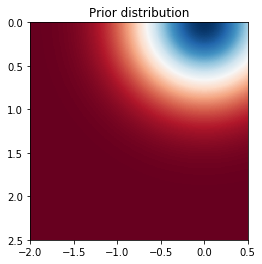

In [94]:
# Computes and displays prior distribution

V, Y = pb.meshgrid(Omega[0], Omega[1])

for i in range(plot_size):
    for j in range(plot_size):
        omega = np.array([Omega[0][i], Omega[1][j]])
        omega = omega.reshape(len(omega),1)
        prior_distribution[i][j] = prior_distribution_fun(omega)

S = prior_distribution.reshape(V.shape)

# extent displays the axis
im = pb.imshow(S, cmap=pb.cm.RdBu, extent=(y_axis[0],y_axis[1],x_axis[1],x_axis[0]))
pb.title("Prior distribution")
pb.show()

In [128]:
# Get the posterior distribution for a random data point

if (plot_option == 0):

    iteration_number = 20
    
    for k in range(iteration_number):
    
        maximum_value = 0
        maximum_index = (0,0)

        index = np.random.randint(0,set_size)
        while (index in point_set):
            index = np.random.randint(0, set_size)
        point_set = np.append(point_set,index)

        point = np.array([X[index],T[index]])
        X_plot = np.append(X_plot,X[index])
        T_plot = np.append(T_plot,T[index])

        for i in range(plot_size):
            for j in range(plot_size):
                omega = np.array([Omega[0][i], Omega[1][j]])
                omega = omega.reshape(len(omega),1)
                if (initialization == True):
                    posterior_distribution[i][j] = point_likelihood(point, omega)*prior_distribution_fun(omega)
                else:
                    posterior_distribution[i][j] *= point_likelihood(point, omega)
                if (posterior_distribution[i][j] > maximum_value):
                    maximum_value = posterior_distribution[i][j]
                    maximum_index = (i,j)

        initialization = False

In [129]:
# Get the posterior distribution on the whole data set

if (plot_option == 1):

    maximum_value = 0
    maximum_index = (0,0)

    for i in range(plot_size):
        for j in range(plot_size):
            likelihood = 1
            omega = np.array([Omega[0][i], Omega[1][j]])
            omega = omega.reshape(len(omega),1)
            for l in range(set_size):
                point = np.array([X[l],T[l]])
                likelihood *= point_likelihood(point, omega)
            posterior_distribution[i][j] = likelihood*prior_distribution_fun(omega)
            if (posterior_distribution[i][j] > maximum_value):
                maximum_value = posterior_distribution[i][j]
                maximum_index = (i,j)

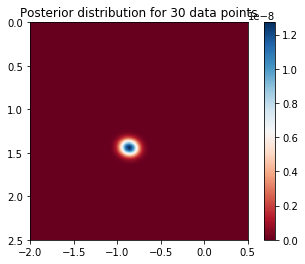

In [130]:
# Plots the posterior distribution over the parameters W

V, Y = pb.meshgrid(Omega[0], Omega[1])
Z = posterior_distribution.reshape(V.shape)

# extent displays the axis
im = pb.imshow(Z, cmap=pb.cm.RdBu, extent=(y_axis[0],y_axis[1],x_axis[1],x_axis[0]))
pb.colorbar(im)
pb.title("Posterior distribution for " + str(len(point_set)) + " data points")
pb.show()

In [131]:
# Finds the parameters of the posterior distribution

imax = maximum_index[0]
jmax = maximum_index[1]
mu_omega_0 = Omega[0][imax]
mu_omega_1 = Omega[1][jmax]

if ((imax == (plot_size-1)) or (imax == 0) or (jmax == (plot_size-1)) or (jmax == 0)):
    print("There ought to be a problem here")

total_area = posterior_distribution[imax, jmax]
stop_array = np.array([0.003,0.046,0.317])
sigma_values = np.zeros(3)
stop_indexes = np.zeros(3)
    
# Gets the covariance on omega_0

current_area = 0
stop_level = 0

if (imax >= plot_size/2):
    distance = plot_size - 1 - imax
    for i in range(distance):
        total_area += 2*posterior_distribution[imax+i+1][jmax]
    for k in range(distance):
        current_area += 2*posterior_distribution[plot_size-1-k][jmax]
        if (current_area > stop_array[stop_level]*total_area):
            stop_indexes[stop_level] = plot_size-1-k
            stop_level += 1
            if (stop_level == 3):
                break
                
    first_index = int(stop_indexes[0])
    second_index = int(stop_indexes[1])
    third_index = int(stop_indexes[2])
    
    sigma_values[0] = (Omega[0][first_index] - mu_omega_0)/3
    sigma_values[1] = (Omega[0][second_index] - mu_omega_0)/2
    sigma_values[2] = Omega[0][third_index] - mu_omega_0
            
elif (imax < plot_size/2):
    distance = imax
    for i in range(distance):
        total_area += 2*posterior_distribution[i][jmax]
    for k in range(distance):
        current_area += 2*posterior_distribution[k][jmax]
        if (current_area > stop_array[stop_level]*total_area):
            stop_indexes[stop_level] = k
            stop_level += 1
            if (stop_level == 3):
                break

    first_index = int(stop_indexes[0])
    second_index = int(stop_indexes[1])
    third_index = int(stop_indexes[2])
    
    sigma_values[0] = (mu_omega_0 - Omega[0][first_index])/3
    sigma_values[1] = (mu_omega_0 - Omega[0][second_index])/2
    sigma_values[2] = mu_omega_0 - Omega[0][third_index]
    
sigma_0 = np.mean(sigma_values)


# Gets the covariance on omega_1

current_area = 0
stop_level = 0

if (jmax >= plot_size/2):
    distance = plot_size - 1 - jmax
    for i in range(distance):
        total_area += 2*posterior_distribution[imax][jmax+i+1]
    for k in range(distance):
        current_area += 2*posterior_distribution[imax][plot_size-1-k]
        if (current_area > stop_array[stop_level]*total_area):
            stop_indexes[stop_level] = plot_size-1-k
            stop_level += 1
            if (stop_level == 3):
                break
                
    first_index = int(stop_indexes[0])
    second_index = int(stop_indexes[1])
    third_index = int(stop_indexes[2])
    
    sigma_values[0] = (Omega[1][first_index] - mu_omega_1)/3
    sigma_values[1] = (Omega[1][second_index] - mu_omega_1)/2
    sigma_values[2] = Omega[1][third_index] - mu_omega_1
            
elif (jmax < plot_size/2):
    distance = jmax
    for i in range(distance):
        total_area += 2*posterior_distribution[imax][i]
    for k in range(distance):
        current_area += 2*posterior_distribution[imax][k]
        if (current_area > stop_array[stop_level]*total_area):
            stop_indexes[stop_level] = k
            stop_level += 1
            if (stop_level == 3):
                break

    first_index = int(stop_indexes[0])
    second_index = int(stop_indexes[1])
    third_index = int(stop_indexes[2])
    
    sigma_values[0] = (mu_omega_1 - Omega[1][first_index])/3
    sigma_values[1] = (mu_omega_1 - Omega[1][second_index])/2
    sigma_values[2] = mu_omega_1 - Omega[1][third_index]
    
sigma_1 = np.mean(sigma_values)



1.44110275689
-0.859649122807
0.0619604566973
0.057783347257


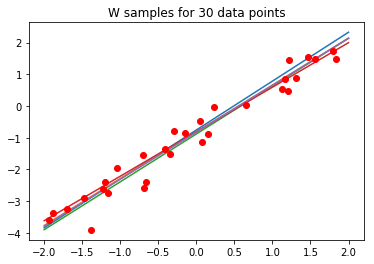

In [132]:
# Plots the points from the data set and some lines obtained from the posterior distribtion

number_of_lines = 5

for i in range(number_of_lines):
    omega_0 = np.random.normal(mu_omega_0, sigma_0)
    omega_1 = np.random.normal(mu_omega_1, sigma_1)
    Z = omega_0*X + omega_1
    plt.plot(X,Z)

print(mu_omega_0)
print(mu_omega_1)
print(sigma_0)
print(sigma_1)

plt.plot(X_plot,T_plot,'ro')
plt.title("W samples for " + str(len(point_set)) + " data points")
plt.show()